# Ofset free MPC using matric C

# Ofset free MPC using matric C

In [247]:
import numpy as np
from numpy.linalg import eig, inv
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [248]:
matrix_C = False

# Load matrices A, B, and C 
A = np.load('./data/A_C_' + str(matrix_C) + '.npy')
B = np.load('./data/B_C_' + str(matrix_C) + '.npy')
C = np.load('./data/C_C_' + str(matrix_C) + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [249]:
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))


Close to block diagonal? True
Backtransformation equals original A? True


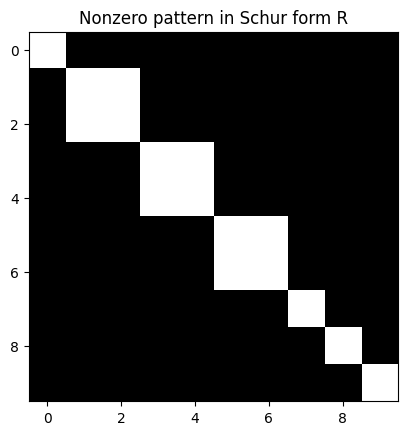

In [250]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(A_transformed) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()

In [251]:
A = A_block
B = inv(T_real) @ B
C = C @ T_real


In [252]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [253]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

# no loss function because only using the model not training it
loss = PenaltyLoss([], constraints=[])

problem = Problem(nodes, loss)

problem.load_state_dict(torch.load('data/model_C_' + str(matrix_C) + '.pth'),strict=False)



<All keys matched successfully>

In [254]:
# load scalers
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [255]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

In [256]:
# probably yes
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1)

## Optimal control problem

Observer - Kalman filter

In [257]:
y_start = np.array([0.5, 0.5])
y_start = scaler.transform(y_start.reshape(1, -1))

y_setpoint = np.array([1.5, 0.8])
y_setpoint = scaler.transform(y_setpoint.reshape(1, -1))[0]

u_previous = np.array([0.2, 0.5])
u_previous = scalerU.transform(u_previous.reshape(1, -1))[0]

z_est_ = np.hstack((get_x(y_start).T, np.zeros((1,nd))))
z_est_[:,:10] = (inv(T_real)@z_est_[:,:10].T).T
P0 = np.eye(nz+nd) 

# Noise covariances
Q = np.eye(nz+nd) * 0.1  # process noise
R = np.eye(ny) * 0.5  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

EKF = helper.EKF(A_,B_,z_est_,P0, problem, Q, R, 2, T_real)


Target calculation

In [258]:
N = 20
Qy = np.eye(ny) *5
Qu = np.eye(nu)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(get_x(y_start).T[0]).float(),
)@T_real

C_k = cp.Parameter((ny, nz))
C_k.value = J


# Constraints
u_min = scalerU.transform(np.array([[0.0, 0.0]]))[0]
u_max = scalerU.transform(np.array([[0.5, 1.0]]))[0]
y_min = scaler.transform(np.array([[0.0, 0.0]]))[0]
y_max = scaler.transform(np.array([[5.0, 5.0]]))[0]

z0 = cp.Parameter(nz)
d0 = cp.Parameter(ny)
d0.value = np.zeros(ny)
u_prev = cp.Parameter(nu)

y_sp = cp.Parameter(ny)
y_sp.value = y_setpoint
# y_sp = y_setpoint
z_ref = cp.Parameter(nz)

# Decision variables
z = cp.Variable((nz, N+1))
y = cp.Variable((ny, N+1))
delta_u = cp.Variable((nu, N))
u = cp.Variable((nu, N + 1)) 
z_s = cp.Variable(nz)
z_k = cp.Parameter(nz)
z_k.value = z_est_[0,:nz]
y_k = cp.Parameter(ny)
y_k.value = get_y(T_real@z_k.value)[0]
y_s = cp.Variable(ny)
u_s = cp.Variable(nu)


In [259]:
get_y(z_k.value)

array([[0.19989   , 0.02245044]], dtype=float32)

In [260]:
y_setpoint

array([ 0.29009362, -0.22054858])

In [261]:
(y_k - C_k@z_k).value

array([-0.38254755, -0.26710627])

In [262]:

# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C_k @ z_s + y_k - C_k @ z_k + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))
print("Desired y:", scaler.inverse_transform(y_sp.value.reshape(1,-1)))
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.31160996 0.92018868]]
Desired y: [[1.5 0.8]]
Optimal u: [[0.5        0.28820819]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [263]:

C_k.value = J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_s.value).float(),
)@T_real
# Constraints and cost
constraints_s = [z_s == A @ z_s + B @ u_s]
constraints_s += [y_s == C_k @ z_s + y_k - C_k @ z_k + F @ d0]
constraints_s += [u_min <= u_s, u_s <= u_max]
constraints_s += [y_min <= y_s, y_s <= y_max]

cost_s = 0
cost_s += cp.quad_form(y_s - y_sp, np.eye(ny))

target_estimation = cp.Problem(cp.Minimize(cost_s), constraints_s)
target_estimation.solve(solver=cp.GUROBI)
print(target_estimation.status)
print("Optimal y:", scaler.inverse_transform(y_s.value.reshape(1,-1)))
print("Desired y:", scaler.inverse_transform(y_sp.value.reshape(1,-1)))
print("Optimal u:", scalerU.inverse_transform(u_s.value.reshape(1,-1)))

z_ref.value = z_s.value

optimal
Optimal y: [[1.27519373 0.95793409]]
Desired y: [[1.5 0.8]]
Optimal u: [[0.5        0.35300911]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [264]:
y_s.value - y_sp.value

array([-0.25233933,  0.21847276])

MPC problem formulation


In [241]:
z0.value = z_est_[0,0:nz]
u_prev.value = u_previous

In [242]:
C_k.value = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_s.value).float(),
)@T_real
J = C_k.value
#!!!!
Qz = J.T@Qy@J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

constraints = [z[:, 0] == z0]
constraints += [u[:, 0] == u_prev + delta_u[:, 0]]
cost = 0
for k in range(N):
    constraints += [u[:, k] == u[:, k-1] + delta_u[:, k]]
    
    constraints += [
        z[:, k+1] == A @ z[:, k] + B @ u[:,k],
        #y[:, k] == C @ z[:, k] + F @ d0,
        y[:, k] == C_k @ z[:, k] + y_k - C_k @ z_k + F @ d0,
        u_min <= u[:, k], u[:, k] <= u_max,
        y_min <= y[:, k], y[:, k] <= y_max
    ]
    cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)

In [243]:
def construct_MPC(J_k):
    J = J_k
    Qz = J.T@Qy@J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    # Constraints and cost
    cost = 0
    for k in range(N):    
        cost += cp.quad_form(z[:, k] - z_ref, Qz_psd) + cp.quad_form(delta_u[:, k], Qu)
    mpc = cp.Problem(cp.Minimize(cost), constraints)
    return mpc
    # Terminal cost - not yet
    # cost += cp.quad_form(x[:, N] - x_ref[:, N], Q)


In [244]:
# sanity check and problem formulation
mpc = cp.Problem(cp.Minimize(cost), constraints)
mpc.solve(solver=cp.GUROBI)
u_opt = u[:,0].value
print(u[:,0].value)
print(mpc.status)

[-0.29077166 -0.50911528]
optimal


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [245]:


sim_time = 150
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))
us_sim = np.zeros((nu, sim_time+1))

y_sp.value = scaler.transform(np.array([[0.5,0.5]]))[0]
target_estimation.solve(solver=cp.GUROBI)
z_ref.value = z_s.value

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))


z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s.value
zs_sim[:, 0] = z_s.value
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]

counter = 0
when = 0
change = False
for k in range(sim_time):
    if k == 50:
        y_sp.value = y_setpoint
    #lin_point = get_x(y_sp.value).T[0]
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_s.value).float(), #
    )@T_real
    if abs(sum(ys_sim[:, k-1]-ys_sim[:, k])) > 0.01 and k > 0: #k in [50,51,52,53]:
        mpc = construct_MPC(J_k)
        counter += 1
        when = k
        change = True
    else:
        change = False
    # solve MPC
    print(ys_sim[:, k])
    mpc.solve(solver=cp.GUROBI)
    u_sim[:, k] = u[:,0].value
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]

    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = EKF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # update initial conditions
    #y0.value = y_sim[:, k+1]
    z0.value = z_sim[:nz, k+1]
    d0.value = z_sim[nz:, k+1]
    z_k.value = z_sim[:nz, k+1]  
    y_k.value = get_y(z_k.value)[0]
    # if change:
    #     C_k.value = J_k
    # else:
    #     C_k.value = helper.evaluate_jacobian(
    #         problem.nodes[4],
    #         torch.from_numpy(z_k.value).float(),
    #     )
        
    C_k.value = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_s.value).float(),
    )@T_real
    target_estimation.solve(solver=cp.GUROBI)
    ys_sim[:, k+1] = y_s.value
    zs_sim[:, k+1] = z_s.value
    us_sim[:, k+1] = u_s.value
    z_ref.value = z_s.value
    u_prev.value = u_sim[:, k]
    print(mpc.status)
    

/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[-0.78807041 -0.67065835]
optimal
[3.52280754 0.29291432]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/problems/problem.py:1510: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


ValueError: cannot convert float NaN to integer

In [ ]:
counter

19

In [ ]:
when

19

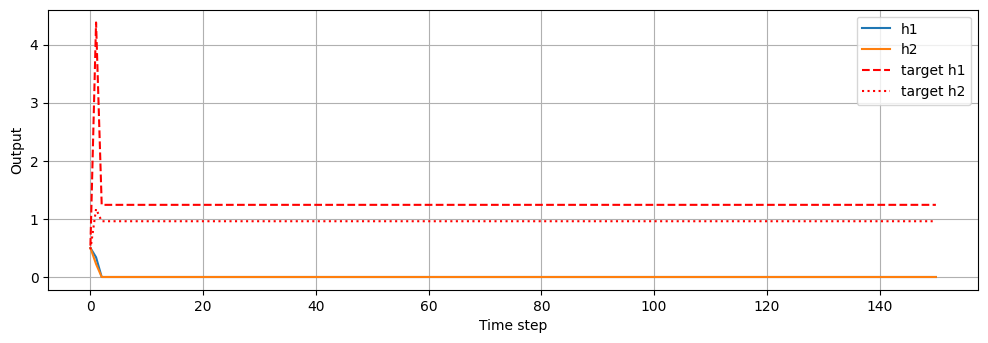

In [246]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0], label='h1')
plt.plot(y_sim_descaled[1], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1], color='red', linestyle=':', label='target h2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [ ]:
sum(y_sim_descaled[0] > 1.58001)

3

In [ ]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [ ]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [ ]:
from sklearn.metrics import mean_squared_error

# Descales ys_sim
ys_sim_descaled = scaler.inverse_transform(ys_sim.T).T

# Compute MSE for each output
mse_h1 = mean_squared_error(ys_sim_descaled[0], y_sim_descaled[0])
mse_h2 = mean_squared_error(ys_sim_descaled[1], y_sim_descaled[1])

print(f"MSE for h1: {mse_h1}")
print(f"MSE for h2: {mse_h2}")

MSE for h1: 1.600112227497368
MSE for h2: 0.8504321101862334


In [ ]:
from numpy import trapz

# Compute ISE for each output
ise_h1 = trapz((ys_sim_descaled[0] - y_sim_descaled[0])**2)
ise_h2 = trapz((ys_sim_descaled[1] - y_sim_descaled[1])**2)

print(f"ISE for h1: {ise_h1}")
print(f"ISE for h2: {ise_h2}")

# 1.081780547953782
# ISE for h2: 0.6261296966708955

ISE for h1: 0.8721885145208028
ISE for h2: 0.39874483626860674


In [ ]:
# Compute the closed-loop value of the objective function

objective_value = 0
for k in range(50,sim_time):
    y_diff = y_sim[:, k] - y_setpoint
    u_diff = u_sim[:, k]
    objective_value += y_diff.T @ Qy @ y_diff + u_diff.T @ Qu @ u_diff

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 66.39799235854578


In [ ]:
z_sim[:nz, -1].flatten()-z_ref.value.flatten()

array([ 1.57492817e-05, -2.74357621e-05,  4.41012617e-05,  1.83183122e-05,
       -4.18435991e-05, -4.10644537e-05, -9.92824835e-06,  2.00876195e-06,
        4.41968978e-05,  4.21062017e-06])

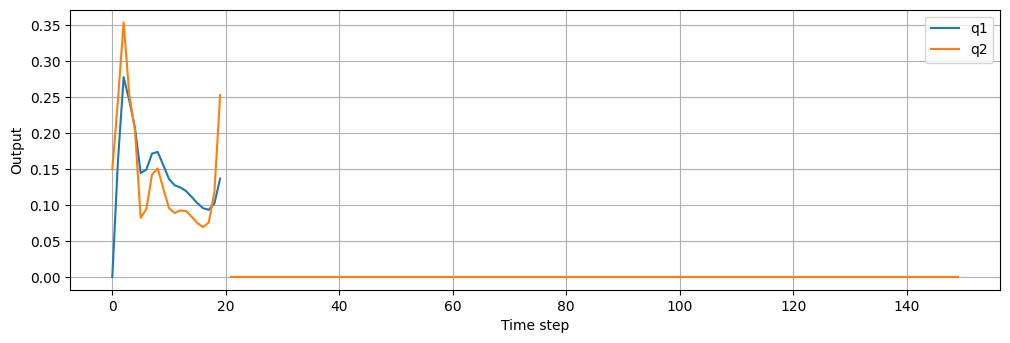

In [ ]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0], label='q1')
plt.plot(u_sim_descaled[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

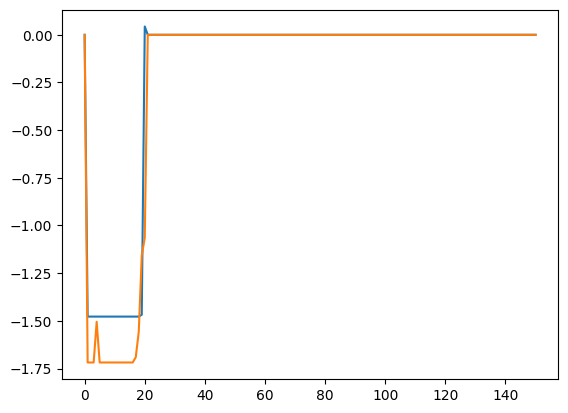

In [ ]:
plt.plot(us_sim.T)

In [ ]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[nan nan]


/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_90197/621697738.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


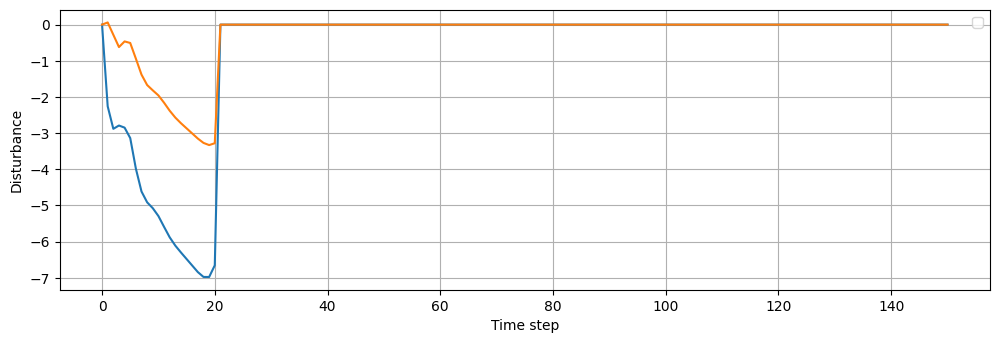

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_90197/4249820153.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


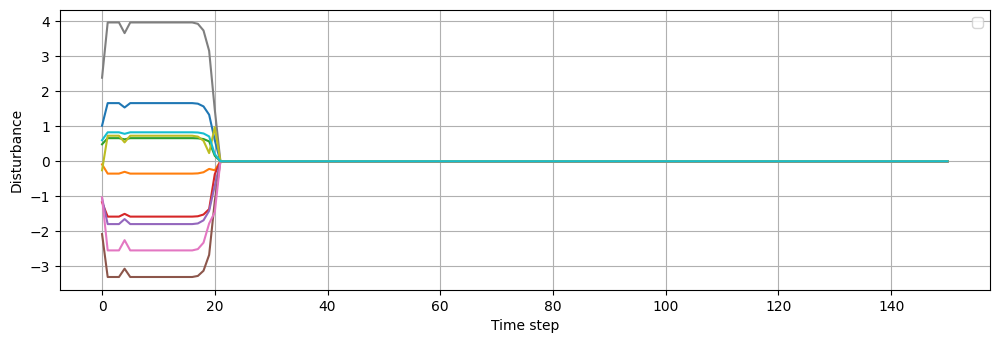

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_90197/2974051967.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


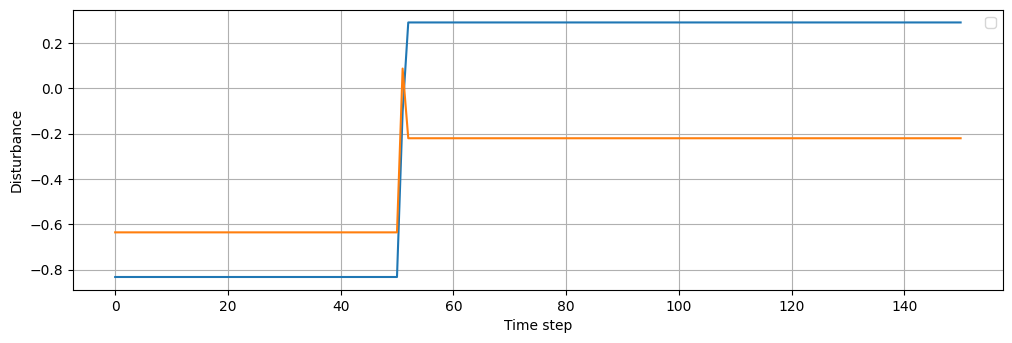

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

In [ ]:
ys_sim[:,40:60]

array([[-0.83238102, -0.83238102, -0.83238102, -0.83238102, -0.83238102,
        -0.83238101, -0.83238101, -0.83238101, -0.83238101, -0.83238102,
        -0.83238102, -0.10345177,  0.29009362,  0.29009362,  0.29009361,
         0.29009362,  0.29009362,  0.29009362,  0.29009362,  0.29009362],
       [-0.6355434 , -0.63554339, -0.63554339, -0.63554339, -0.6355434 ,
        -0.6355434 , -0.6355434 , -0.6355434 , -0.6355434 , -0.63554339,
        -0.6355434 ,  0.08676579, -0.22054858, -0.22054858, -0.22054857,
        -0.22054858, -0.22054858, -0.22054858, -0.22054858, -0.22054858]])

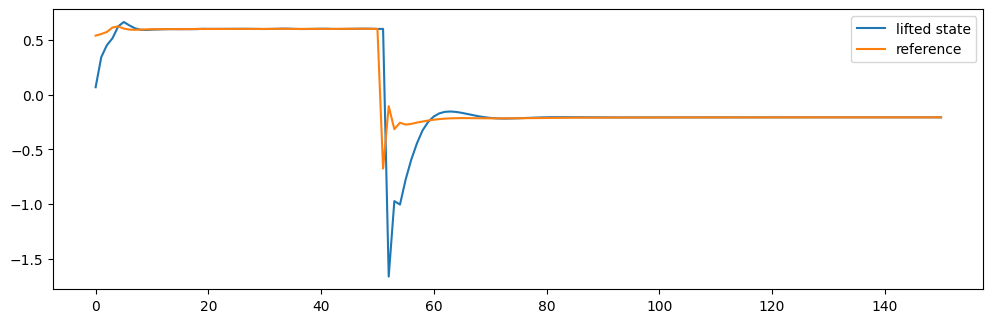

In [ ]:
lifted_state = 2
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[lifted_state].T, label = 'lifted state')
plt.plot(zs_sim[lifted_state].T, label = 'reference')
legend = plt.legend()


## comparison with Jackobian

In [ ]:
start = 0
end = 70

y_C = C@z_sim[:nz,start:end] + z_sim[nz:,start:end]
y_C_sp = J_k@z_sim[:nz,start:end] - J_k@z_s.value.reshape(-1,1) + get_y(z_k.value).T + z_sim[nz:,start:end]

J_k = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_sim[:nz,start]).float(),
)@T_real
y_Cstart = J_k@z_sim[:nz,start:end] - J_k@z_sim[:nz,start].reshape(-1,1) + get_y(z_sim[:nz,start]).T + z_sim[nz:,start:end]

y_Ck = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_sim[:nz,i]).float(),
    )@T_real
    y_Ck[:,i-start] = J_k@z_sim[:nz,i] - J_k@z_sim[:nz,i] + get_y(z_sim[:nz,i]) + z_sim[nz:,i]

y_Ck_sp = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(zs_sim[:nz,i]).float(),
    )@T_real
    y_Ck_sp[:,i-start] = J_k@z_sim[:nz,i] - J_k@zs_sim[:nz,i] + get_y(zs_sim[:nz,i]) + z_sim[nz:,i]

x0 = get_x(y_sim[:,start])
x_p = np.zeros((nz, (end-start)+1))
y_xh = np.zeros((ny, (end-start)))
x_p[:,0] = x0.flatten()
for i in range(start, end):
    x_p[:,i+1-start] = A @ x_p[:,i-start] + B @ u_sim[:,i]
    x0 = x_p[:,i-start]
    y_xh[:,i-start] = get_y(x_p[:,i-start]) + z_sim[nz:,i]

# descale
y_C = scaler.inverse_transform(y_C.T).T
y_C_sp = scaler.inverse_transform(y_C_sp.T).T
y_Ck = scaler.inverse_transform(y_Ck.T).T
y_Cstart = scaler.inverse_transform(y_Cstart.T).T
y_Ck_sp = scaler.inverse_transform(y_Ck_sp.T).T
descaled_sp = scaler.inverse_transform(y_setpoint.reshape(1,-1))[0]
y_xh = scaler.inverse_transform(y_xh.T).T

In [ ]:
# # find first index in ysim[0] > 1.58001
# y_sim_descaled[0] > 1.58001
# # index of true values
# # find first index in ysim[0] > 1.58001
# for i in range(len(y_sim_descaled[0])):
#     if np.all(y_sim_descaled[0][i] > 1.58001):
#         print("First convergence index:", i)
#         break
# # plot results

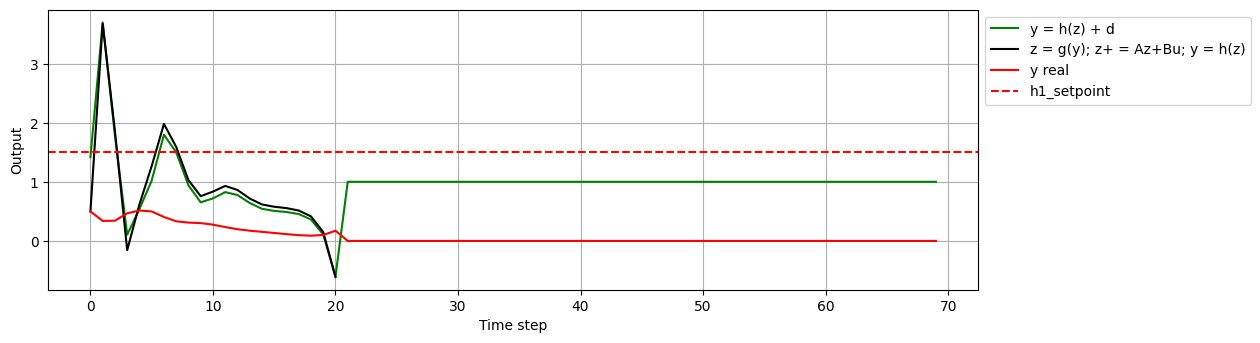

In [ ]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
#plt.plot(y_C[0], label='y = Cz + d', color='blue')
#plt.plot(y_C_sp[0], label='y = C_sp z +d', color='brown')
plt.plot(y_Ck[0], label='y = h(z) + d', color='green')
#plt.plot(y_Cstart[0], label='y = C_start z + d', color='purple')
#plt.plot(y_Ck_sp[0], label='y = C_lastsp z +d ', color='orange')
plt.plot(y_xh[0], label='z = g(y); z+ = Az+Bu; y = h(z)', color='black')

plt.plot(y_sim_descaled[0, start:end], label='y real', color='red')
# plot yref as dashed line as a horizontal line
plt.axhline(y=descaled_sp[0], color='r', linestyle='--', label='h1_setpoint')
# legend outside
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)


In [ ]:
ise_h1_y_C = trapz((y_C[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C: {ise_h1_y_C}")

ise_h1_y_C_sp = trapz((y_C_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C_sp: {ise_h1_y_C_sp}")

ise_h1_y_Ck = trapz((y_Ck[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck: {ise_h1_y_Ck}")

ise_h1_y_Cstart = trapz((y_Cstart[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Cstart: {ise_h1_y_Cstart}")

ise_h1_y_Ck_sp = trapz((y_Ck_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck_sp: {ise_h1_y_Ck_sp}")

ise_h1_y_xh = trapz((y_xh[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_xh: {ise_h1_y_xh}")

ISE for h1 y_C: 0.5255396980711435
ISE for h1 y_C_sp: 1.0784336987430554
ISE for h1 y_Ck: 0.1741490829254287
ISE for h1 y_Cstart: 7.565499700234023
ISE for h1 y_Ck_sp: 0.9411231270069962
ISE for h1 y_xh: 0.053351077590162416


# prediction

In [ ]:
A @ z_sim[:nz,i] + B @ u_sim[:,i]

array([ 0.32703213, -0.60427491, -0.21223815, -0.35628118,  0.14720126,
        0.30129185,  0.21810365, -0.03339098,  1.1037713 ,  0.28151676])

In [ ]:
start = 50+3
end = 70
z_sim_copy = z_sim.copy()
for i in range(start, end):
    z_sim_copy[:nz,i+1] = A @ z_sim_copy[:nz,i] + B @ u_sim[:,i]

y_C = C@z_sim_copy[:nz,start:end] + z_sim_copy[nz:,start].reshape(-1,1)
    
y_C_sp = J_k@z_sim_copy[:nz,start:end] - J_k@z_s.value.reshape(-1,1) + get_y(z_k.value).T + z_sim_copy[nz:,start].reshape(-1,1)

J_k = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(z_sim_copy[:nz,start]).float(),
)@T_real
y_Cstart = J_k@z_sim_copy[:nz,start:end] - J_k@z_sim_copy[:nz,start].reshape(-1,1) + get_y(z_sim_copy[:nz,start]).T + z_sim_copy[nz:,start].reshape(-1,1)

y_Ck = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(z_sim_copy[:nz,i]).float(),
    )@T_real
    y_Ck[:,i-start] = J_k@z_sim_copy[:nz,i] - J_k@z_sim_copy[:nz,i] + get_y(z_sim_copy[:nz,i]) + z_sim_copy[nz:,start]

y_Ck_sp = np.zeros((ny, end-start))
for i in range(start, end):
    J_k = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(zs_sim[:nz,i]).float(),
    )@T_real
    y_Ck_sp[:,i-start] = J_k@z_sim_copy[:nz,i] - J_k@zs_sim[:nz,i] + get_y(zs_sim[:nz,i]) + z_sim_copy[nz:,start]

x0 = get_x(y_sim[:,start])
x_p = np.zeros((nz, (end-start)+1))
y_xh = np.zeros((ny, (end-start)))
x_p[:,0] = x0.flatten()
for i in range(start, end):
    x_p[:,i+1-start] = A @ x_p[:,i-start] + B @ u_sim[:,i]
    x0 = x_p[:,i-start]
    y_xh[:,i-start] = get_y(x_p[:,i-start]) #+ z_sim_copy[nz:,start]

# descale
y_C = scaler.inverse_transform(y_C.T).T
y_C_sp = scaler.inverse_transform(y_C_sp.T).T
y_Ck = scaler.inverse_transform(y_Ck.T).T
y_Cstart = scaler.inverse_transform(y_Cstart.T).T
y_Ck_sp = scaler.inverse_transform(y_Ck_sp.T).T
descaled_sp = scaler.inverse_transform(y_setpoint.reshape(1,-1))[0]
y_xh = scaler.inverse_transform(y_xh.T).T

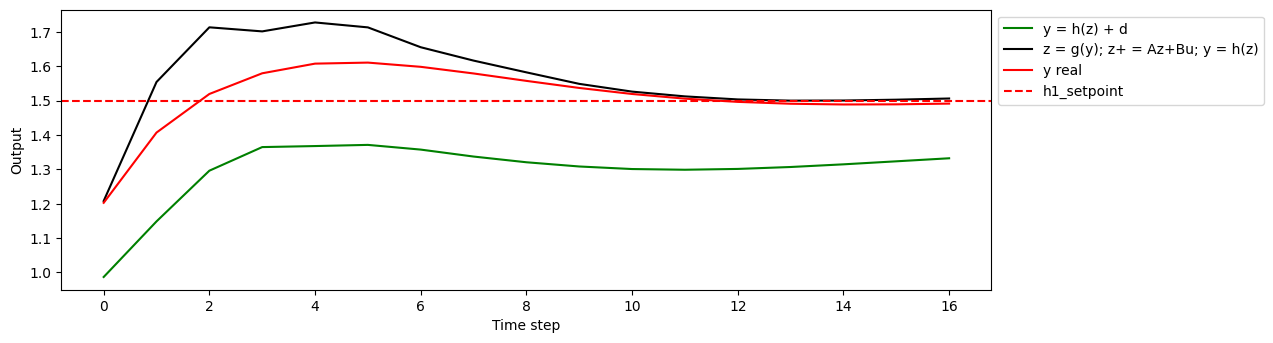

In [ ]:

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
#plt.plot(y_C[0], label='y = Cz + d', color='blue')
#plt.plot(y_C_sp[0], label='y = C_sp z +d', color='brown')
plt.plot(y_Ck[0], label='y = h(z) + d', color='green')
#plt.plot(y_Cstart[0], label='y = C_start z + d', color='purple')
#plt.plot(y_Ck_sp[0], label='y = C_lastsp z +d ', color='orange')
plt.plot(y_xh[0], label='z = g(y); z+ = Az+Bu; y = h(z)', color='black')

plt.plot(y_sim_descaled[0, start:end], label='y real', color='red')
# plot yref as dashed line as a horizontal line
plt.axhline(y=descaled_sp[0], color='r', linestyle='--', label='h1_setpoint')
# legend outside
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
ise_h1_y_C = trapz((y_C[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C: {ise_h1_y_C}")

ise_h1_y_C_sp = trapz((y_C_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_C_sp: {ise_h1_y_C_sp}")

ise_h1_y_Ck = trapz((y_Ck[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck: {ise_h1_y_Ck}")

ise_h1_y_Cstart = trapz((y_Cstart[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Cstart: {ise_h1_y_Cstart}")

ise_h1_y_Ck_sp = trapz((y_Ck_sp[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_Ck_sp: {ise_h1_y_Ck_sp}")

ise_h1_y_xh = trapz((y_xh[0] - y_sim_descaled[0, start:end])**2)
print(f"ISE for h1 y_xh: {ise_h1_y_xh}")

ISE for h1 y_C: 0.14956025573044873
ISE for h1 y_C_sp: 0.8661322885407362
ISE for h1 y_Ck: 0.7593328130238113
ISE for h1 y_Cstart: 1.3471064668321961
ISE for h1 y_Ck_sp: 0.8969322554892314
ISE for h1 y_xh: 0.10521095322531863
